In [70]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 10, 6
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels

pol = ['../propfair/results/workdirs/propfair_hotelres_160_None_0327193732/hr-client.csv',
       '../ucbopt/results/workdirs/ucbopt_hotelres_160_None_0328152359/hr-client.csv']

TIME_ELAPSED = 'time_elapsed'
ALLOC_PER_UNIT_LOAD = 'alloc_per_unit_load'
EVENT_TIME_PERIOD = 'event_time_period'
EVENT_START_TIME = 'event_start_time'
EVENT_END_TIME = 'event_end_time'
P99 = 'p99'
AVG_LATENCY = 'avg_latency'
CUM_P99 = 'cum_p99'
CUM_AVG_LATENCY = 'cum_avg_latency'
LOAD = 'load'

deploys = ['root--consul', 'root--frontend', 'root--geo', 'root--jaeger', 'root--memcached-profile', 
           'root--memcached-rate', 'root--memcached-reserve', 'root--mongodb-geo', 
           'root--mongodb-profile', 'root--mongodb-rate', 'root--mongodb-recommendation', 
           'root--mongodb-reservation', 'root--mongodb-user', 'root--profile', 'root--rate', 
           'root--recommendation', 'root--reservation', 'root--search', 'root--user']

798
798
616
616


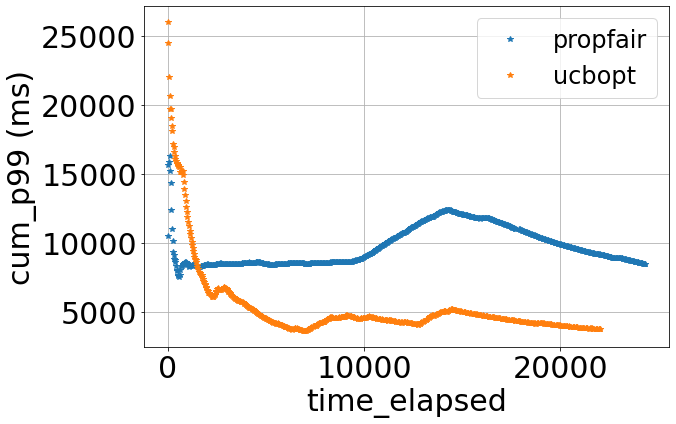

In [76]:
## Graph from Cilantro paper
def getRet(p):
    df = pd.read_csv(p, index_col=0)
    ret = []
    for _, row in df.iterrows():
        curr_data = {EVENT_TIME_PERIOD: row['event_end_time'] - row['event_start_time'],
                             P99: row['p99'],
                             AVG_LATENCY: row['avg_latency'],
                             EVENT_START_TIME: row['event_start_time'],
                             EVENT_END_TIME: row['event_end_time'],
                             LOAD: row['load'],
                            }
        deps = eval(row['allocs'])
        for d in deploys:
            curr_data[d] = deps[d]
            
        ret.append(curr_data)
    ret.sort(key= lambda elem: elem['event_start_time'])
    exp_start_time = ret[0]['event_start_time']
    cum_p99_sum = 0
    cum_avg_lat_sum = 0
    for idx, elem in enumerate(ret):
        elem[TIME_ELAPSED] = elem[EVENT_START_TIME] - exp_start_time
        elem['idx'] = idx
        cum_p99_sum += elem[P99]
        cum_avg_lat_sum += elem[AVG_LATENCY]
        elem[CUM_P99] = cum_p99_sum / (idx + 1)
        elem[CUM_AVG_LATENCY] = cum_avg_lat_sum / (idx + 1)
    return ret


rets = {}
rets['propfair'] = getRet(pol[0])
rets['ucbopt'] = getRet(pol[1])
fig, ax = plt.subplots(1, 1)

for k, v in rets.items():    
    y_vals = [elem[CUM_P99] for elem in v]
    x_vals = [elem[TIME_ELAPSED] for elem in v]

    print(len(x_vals))
    print(len(y_vals))

    ax.errorbar(x_vals, y_vals, fmt="*", label=f"{k}")
    
ax.set_xlabel(f"{TIME_ELAPSED}")
ax.set_ylabel(f"{CUM_P99} (ms)")
ax.grid(True)
ax.legend(fontsize=24)
plt.tight_layout()
plt.show()

#for idx, elem in enumerate(ret):
#    print(idx, elem['event_start_time'])

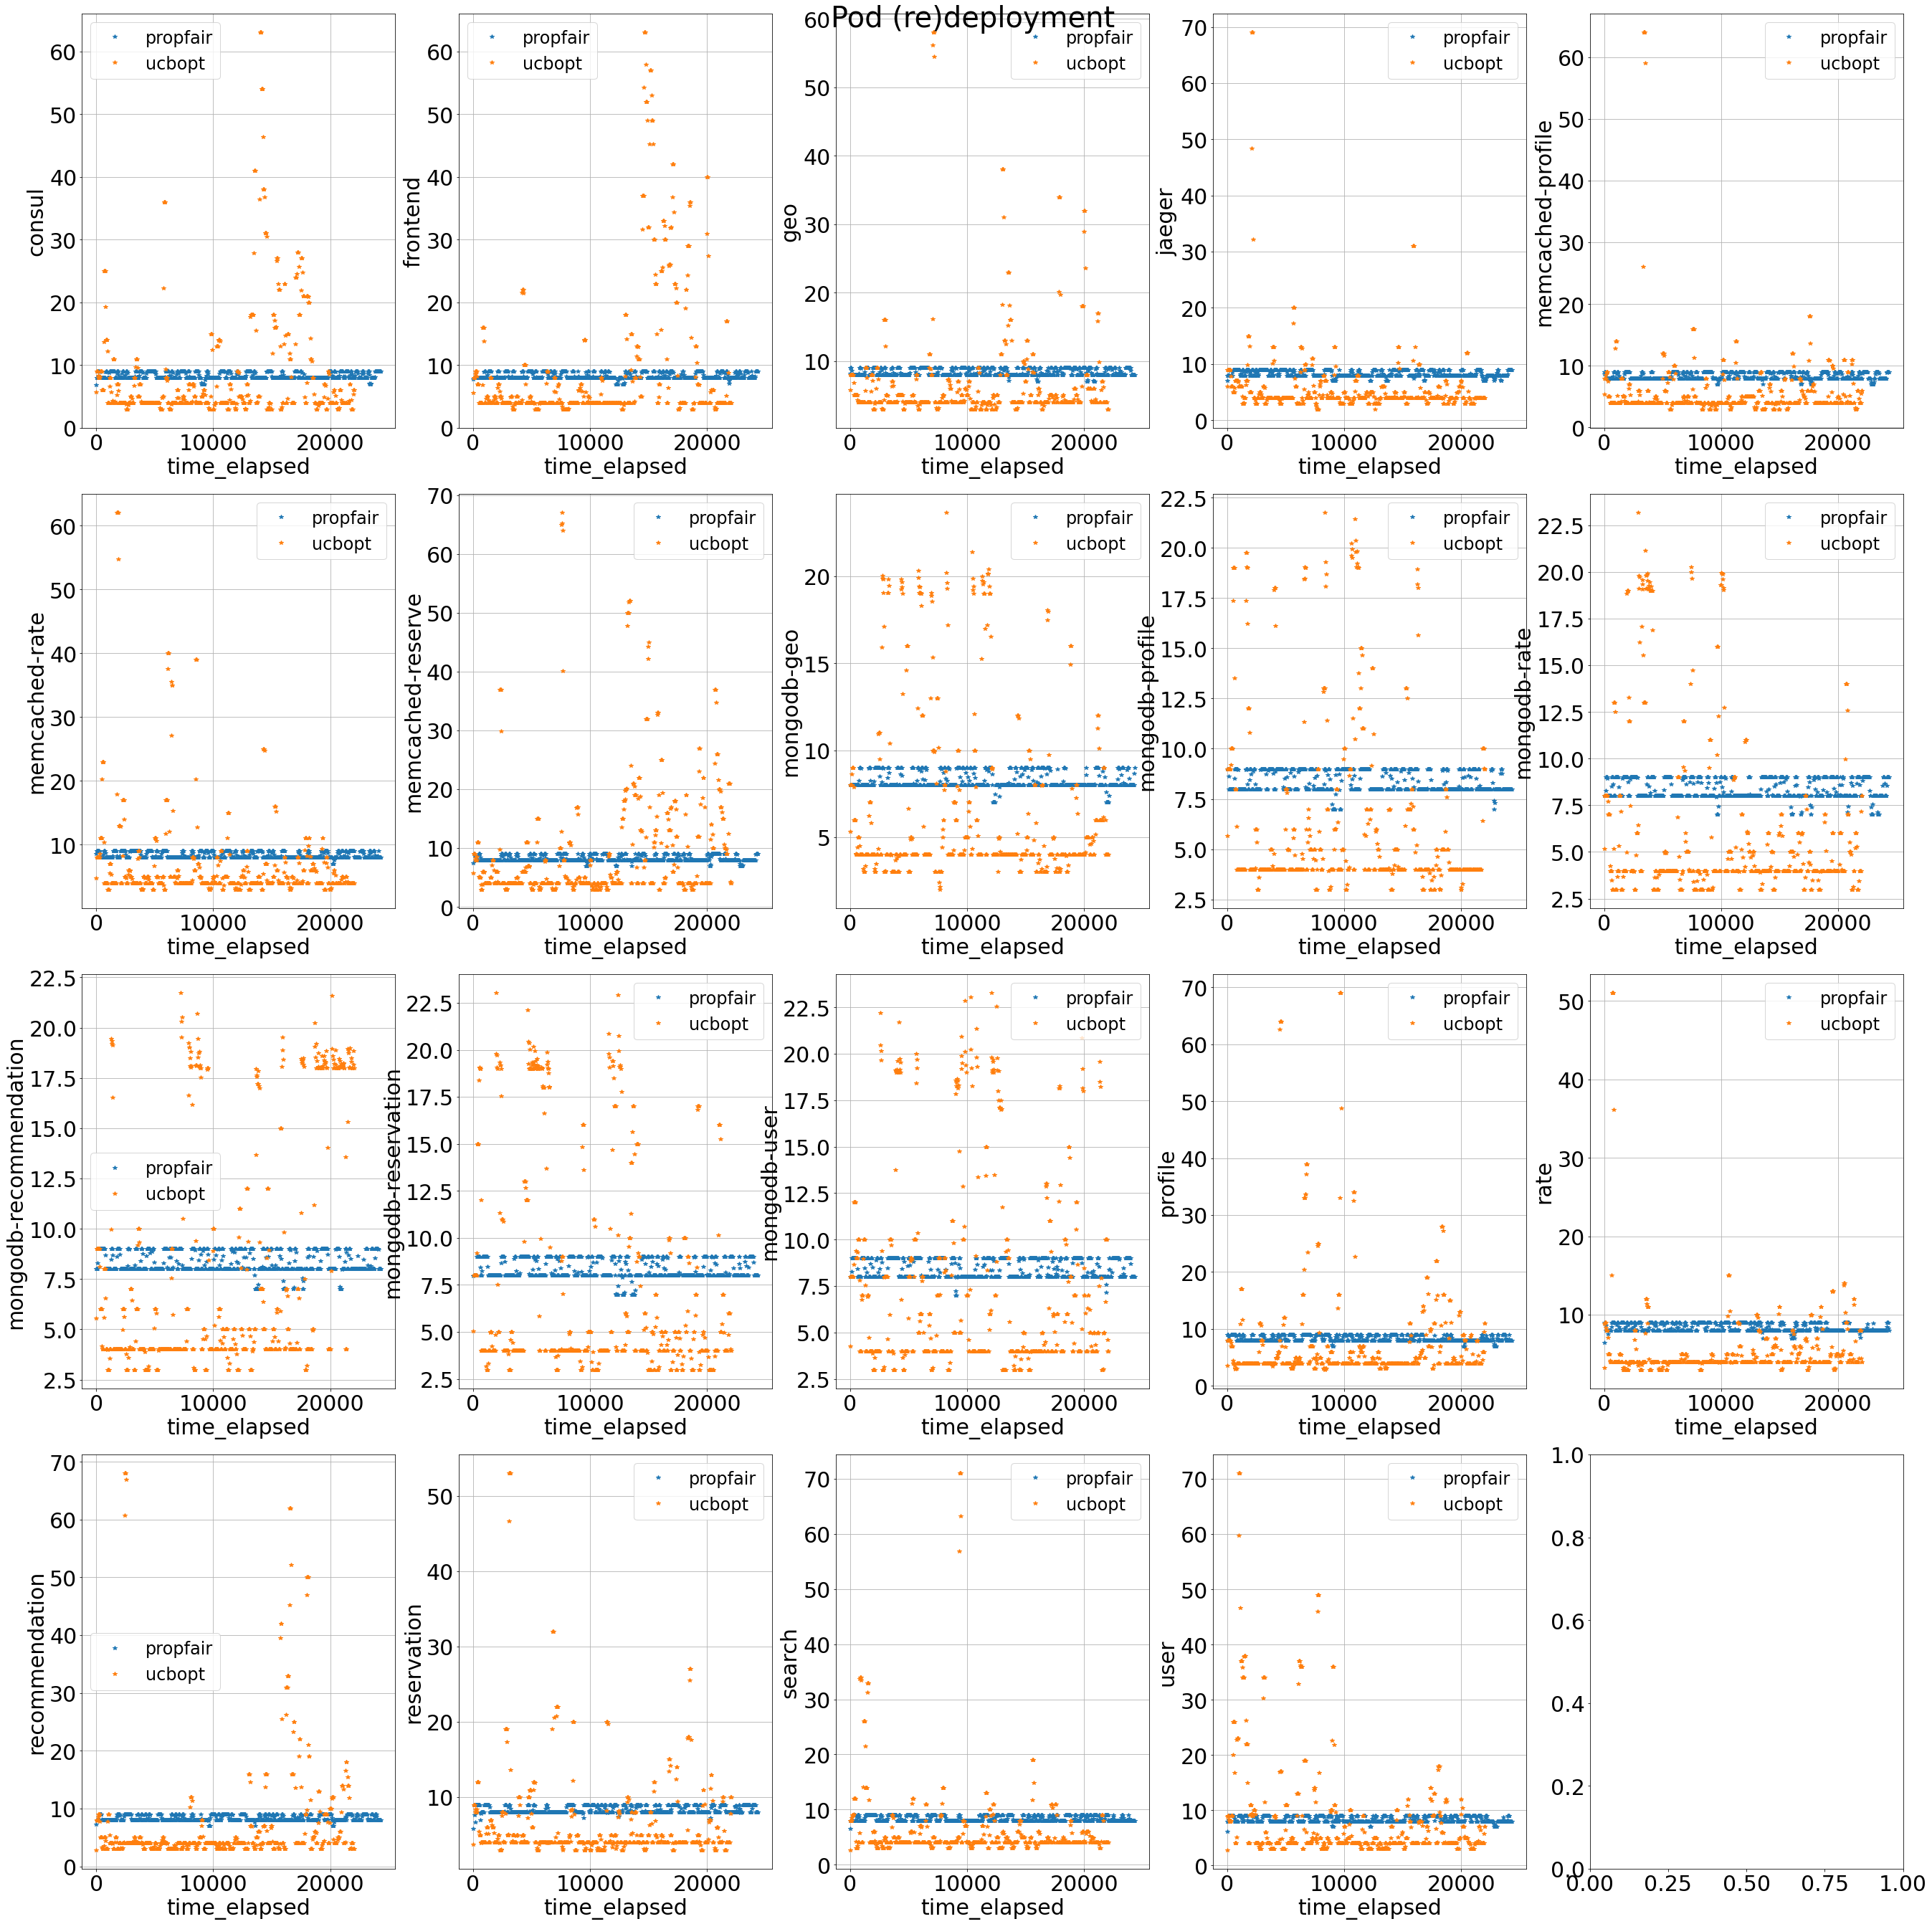

In [102]:
## Graphing live redployment of pods
plt.rcParams['figure.figsize'] = 37, 38
fig, axs = plt.subplots(4, 5)
#print(len(deploys))
fig.suptitle("Pod (re)deployment", fontsize=40)
for i, ax in enumerate(axs.flat):
    if i == 19:
        continue
    for k, v in rets.items():
        x_vals = [elem[TIME_ELAPSED] for elem in v]
        y_vals = [elem[deploys[i]] for elem in v]        
        ax.errorbar(x_vals, y_vals, fmt="*", label=f"{k}")
        
    ax.set_xlabel(f"{TIME_ELAPSED}")
    ax.set_ylabel(f"{deploys[i].split('--')[1]}")
    ax.grid(True)
    ax.legend(fontsize=24)
plt.tight_layout()
plt.show()

In [136]:
import os
def extract_number(s):
    return int(s.split(".")[1])
# Function to recursively extract temp_input numbers from nested dictionaries
def extract_temp_input(d):
    temp_input_numbers = []
    for key, value in d.items():
        if isinstance(value, dict):
            temp_input_numbers.extend(extract_temp_input(value))
        elif key.endswith('_input'):
            temp_input_numbers.append(value)
    return temp_input_numbers

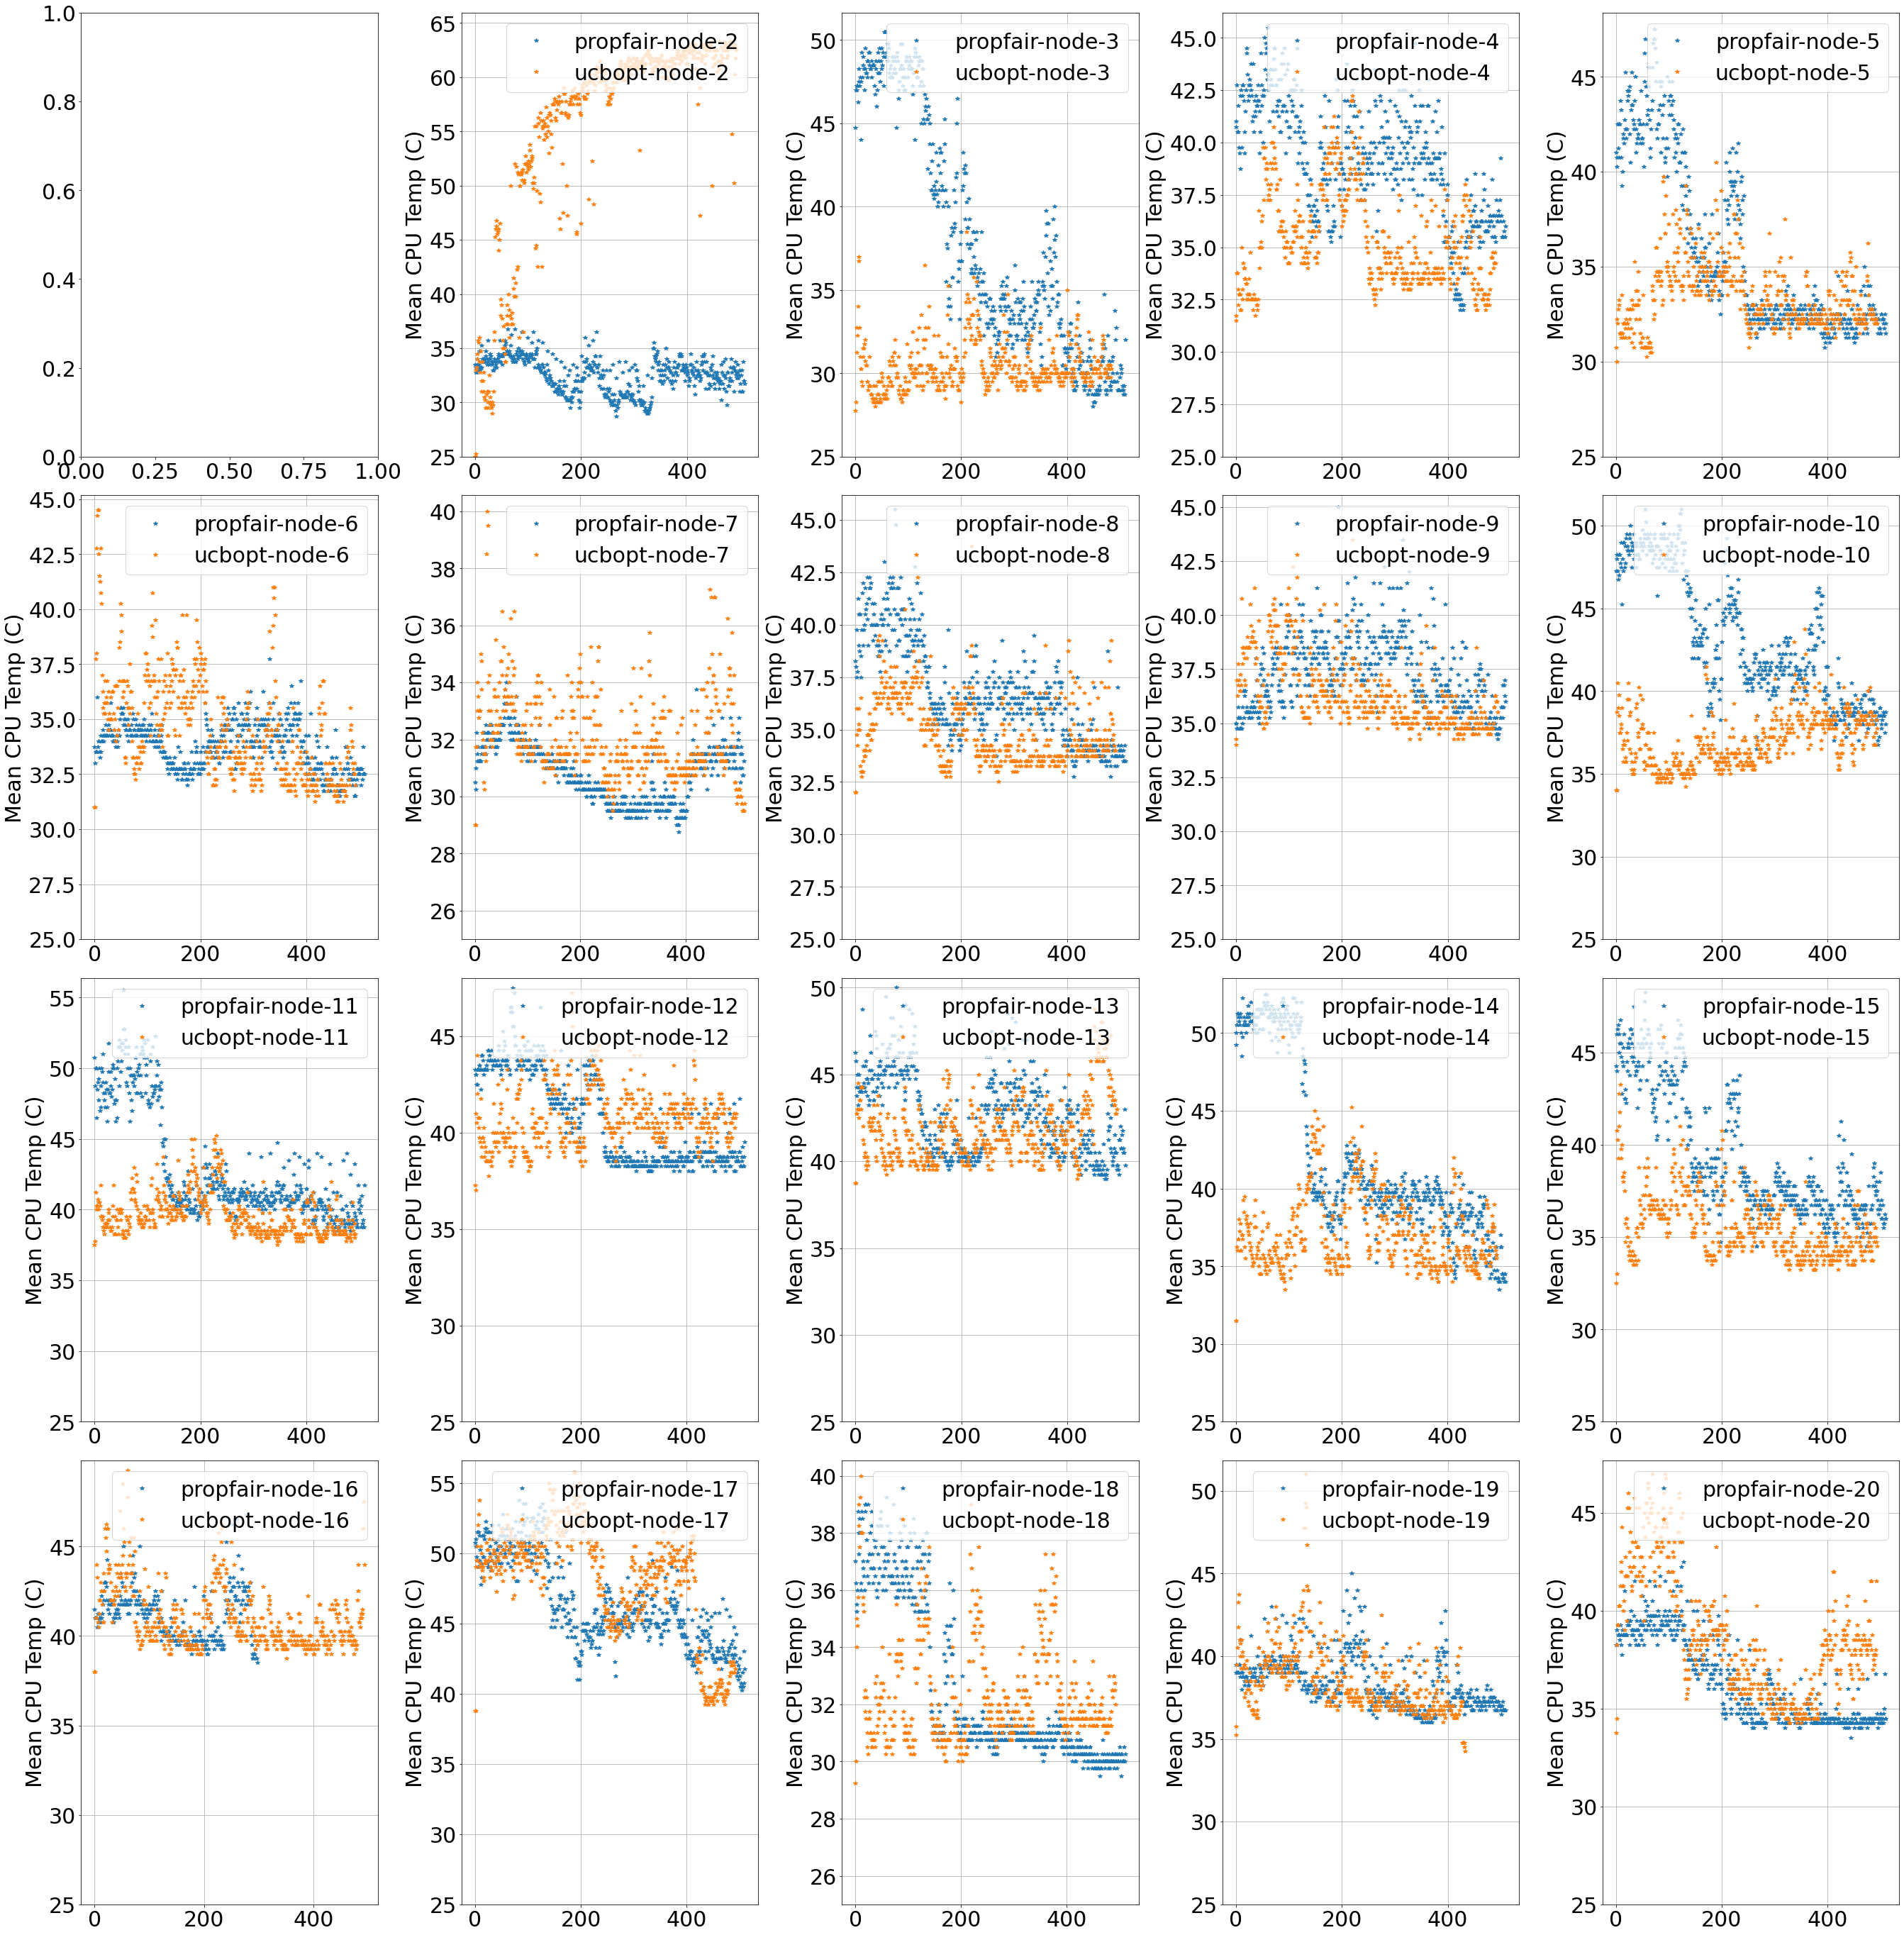

In [147]:
plt.rcParams['figure.figsize'] = 37, 38
fig, axs = plt.subplots(4, 5)
for i, ax in enumerate(axs.flat):
    if (i+1) > 1:
        propfiles = [f for f in os.listdir(f"../propfair/results/10-10-1-{i+1}-sensors")]
        propsfiles = sorted(propfiles, key=extract_number)
        
        propmeantemp=[]
        for sf in propsfiles:
            with open(f"../propfair/results/10-10-1-{i+1}-sensors/{sf}") as f:
                d = f.read()
            ed = eval(d)
            meantemp = np.mean(extract_temp_input(ed))
            propmeantemp.append(meantemp)
            stdtemp = round(np.std(extract_temp_input(ed)), 2)
        
        ax.errorbar(range(0, len(propmeantemp)), propmeantemp, fmt="*", label=f"propfair-node-{i+1}")
        
        ucbfiles = [f for f in os.listdir(f"../ucbopt/results/10-10-1-{i+1}-sensors")]
        ucbsfiles = sorted(ucbfiles, key=extract_number)
        
        ucbmeantemp=[]
        for sf in ucbsfiles:
            with open(f"../ucbopt/results/10-10-1-{i+1}-sensors/{sf}") as f:
                d = f.read()
            ed = eval(d)
            meantemp = np.mean(extract_temp_input(ed))
            ucbmeantemp.append(meantemp)
            stdtemp = round(np.std(extract_temp_input(ed)), 2)
        
        ax.errorbar(range(0, len(ucbmeantemp)), ucbmeantemp, fmt="*", label=f"ucbopt-node-{i+1}")
        
        ax.set_ylabel(f"Mean CPU Temp (C)")
        ax.set_ylim(bottom=25)
        ax.grid(True)
        ax.legend(loc='upper right', fontsize=30)
plt.tight_layout()
plt.show()    